##LOAD DRIVE

In [15]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # Access root folder
# import os
# os.chdir("/content/drive/MyDrive/")

In [ ]:
# !ls data/WhichWaste_dataset

ls: cannot access 'data/WhichWaste_dataset': No such file or directory


In [16]:
# Unzip Dataset
!unzip '/content/drive/MyDrive/WhichWaste_dataset.zip' -d ./data

Archive:  /content/drive/MyDrive/WhichWaste_dataset.zip
replace ./data/WhichWaste_dataset/test/alu_can/dev-alu_can-10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## CODE

### MODEL 1 - No Training + ELMClassifier With Voting

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import ResNet101, DenseNet169, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

class ELMClassifier:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.input_weights = np.random.randn(input_size, hidden_size)
        self.bias = np.random.randn(hidden_size)
        self.output_weights = None

    def fit(self, X_train, y_train):
        hidden_output = np.dot(X_train, self.input_weights) + self.bias
        hidden_output = np.tanh(hidden_output)

        self.output_weights = np.dot(np.linalg.pinv(hidden_output), y_train)

    def predict(self, X_test):
        hidden_output = np.dot(X_test, self.input_weights) + self.bias
        hidden_output = np.tanh(hidden_output)

        predicted_output = np.dot(hidden_output, self.output_weights)

        return predicted_output

def build_feature_extraction_model(base_model, input_shape):
    base_cnn = base_model(weights='imagenet', include_top=False, input_shape=input_shape)
    base_cnn.trainable = False

    # Create a new input tensor
    input_layer = Input(shape=input_shape)

    # Connect the input tensor to the base model
    features = base_cnn(input_layer)

    pooled_features = GlobalAveragePooling2D()(features)
    return Model(inputs=input_layer, outputs=pooled_features)

# Define input shape
input_shape = (224, 224, 3)

# Build feature extraction models for ResNet101, DenseNet169, ResNet50
resnet101_model = build_feature_extraction_model(ResNet101, input_shape)
densenet169_model = build_feature_extraction_model(DenseNet169, input_shape)
resnet50_model = build_feature_extraction_model(ResNet50, input_shape)

# Define input layers for each model
input_resnet101 = Input(shape=input_shape)
input_densenet169 = Input(shape=input_shape)
input_resnet50 = Input(shape=input_shape)

# Connect each input layer to its corresponding model
output_resnet101 = resnet101_model(input_resnet101)
output_densenet169 = densenet169_model(input_densenet169)
output_resnet50 = resnet50_model(input_resnet50)

# Concatenate the extracted features
concatenated_features = concatenate([output_resnet101, output_densenet169, output_resnet50])

# Define the combined model
combined_model = Model(inputs=[input_resnet101, input_densenet169, input_resnet50], outputs=concatenated_features)

# Define dataset directories
train_dir = './data/WhichWaste_dataset/train'
test_dir = './data/WhichWaste_dataset/test'
val_dir = './data/WhichWaste_dataset/val'

# Define image data generators for train, test, and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load images and labels from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Train ELM classifier
elm = ELMClassifier(input_size=concatenated_features.shape[1], hidden_size=1000)

# Evaluate concatenated features using Keras backend
combined_features_value = combined_model.predict([val_generator.next()[0]]*3)

# Train ELM classifier using the evaluated value
X_train, y_train = train_generator.next()
elm.fit(combined_features_value, y_train)

# Prepare validation data for feature extraction
X_val_features_resnet101 = resnet101_model.predict(val_generator)
X_val_features_densenet169 = densenet169_model.predict(val_generator)
X_val_features_resnet50 = resnet50_model.predict(val_generator)

X_val_combined_features = np.concatenate([X_val_features_resnet101, X_val_features_densenet169, X_val_features_resnet50], axis=1)

# Predict using ELM ensemble
predictions = elm.predict(X_val_combined_features)

# Implement majority voting scheme
ensemble_predictions = np.argmax(predictions, axis=1)
ensemble_counts = np.bincount(ensemble_predictions)

# Get the class label with the highest number of votes
ensemble_final_label = np.argmax(ensemble_counts)

# Get true labels from validation generator
true_labels = val_generator.classes

# Calculate accuracy
accuracy = np.mean(ensemble_final_label == true_labels)
print("Validation Accuracy:", accuracy)


Found 37078 images belonging to 24 classes.
Found 4012 images belonging to 24 classes.
Found 3970 images belonging to 24 classes.
125/125 [==============================] - 17s 133ms/step
Validation Accuracy: 0.041561712846347604


### MODEL 2 - Resnet101 For Feature Extraction + ELM For Training

In [ ]:
pip install scikit-elm

In [ ]:
from skelm import ELMClassifier
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to build ResNet101 feature extraction model
def build_resnet101_feature_extraction_model(input_shape):
    # Define base CNN model (ResNet101)
    base_cnn_resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
    base_cnn_resnet101.trainable = False

    # Extract features using ResNet101
    input_layer = Input(shape=input_shape)
    resnet101_features = base_cnn_resnet101(input_layer)
    resnet101_features = GlobalAveragePooling2D()(resnet101_features)

    return Model(inputs=input_layer, outputs=resnet101_features)

# Define input shape
input_shape = (224, 224, 3)

# Build ResNet101 feature extraction model
resnet101_model = build_resnet101_feature_extraction_model(input_shape)

# Define ELM classifier
elm_classifier = ELMClassifier()

# Add a dense layer with the number of classes for classification
num_classes = 24  # Number of output classes
output_layer = Dense(num_classes, activation='softmax')(resnet101_model.output)

# Create the combined model
combined_model = Model(inputs=resnet101_model.input, outputs=output_layer)
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
combined_model.summary()

# Set the paths to your dataset
train_data_dir = './data/WhichWaste_dataset/train'
validation_data_dir = './data/WhichWaste_dataset/val'

# Set image size
img_size = (224, 224)

# Data Augmented already
# So create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

# Load and prepare training data
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
epochs = 10
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)
combined_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# Evaluate the model on the validation set
loss, accuracy = combined_model.evaluate(validation_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 24)                49176     
                                                                 
Total params: 42707352 (162.92 MB)
Trainable params: 49176 (192.09 KB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________
Found 37078 images belonging to 24 classes.
Found 3970 images belonging to 24

In [ ]:
# Additional evaluation metrics
predictions = combined_model.predict(validation_generator)
predicted_classes = predictions.argmax(axis=-1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Calculate additional metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))

63/63 [==============================] - 22s 341ms/step - loss: 0.2203 - accuracy: 0.9421
Validation Loss: 0.22033748030662537
Validation Accuracy: 0.9420654773712158
63/63 [==============================] - 28s 422ms/step

Classification Report:
                    precision    recall  f1-score   support

           alu_can       0.03      0.03      0.03       168
           battery       0.04      0.05      0.05       169
              book       0.03      0.03      0.03       164
     bulky_rubbish       0.06      0.07      0.07       171
         cardboard       0.07      0.06      0.07       173
            cd_dvd       0.08      0.08      0.08       163
    coffee_capsule       0.04      0.04      0.04       165
construction_waste       0.04      0.04      0.04       165
              cork       0.03      0.03      0.03       172
           electro       0.06      0.06      0.06       171
   lithium_battery       0.02      0.02      0.02       165
             metal       0.03   

In [ ]:
# Set the path to your test dataset
test_data_dir = './data/WhichWaste_dataset/test'

# Load and prepare test data
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent ordering for predictions and true labels
)

# Evaluate the model on the test set
test_loss, test_accuracy = combined_model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test set
test_predictions = combined_model.predict(test_generator)
test_predicted_classes = test_predictions.argmax(axis=-1)
test_true_classes = test_generator.classes

# Calculate additional metrics for the test set
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report (Test Set):")
print(classification_report(test_true_classes, test_predicted_classes, target_names=class_labels))

print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(test_true_classes, test_predicted_classes))



Found 4012 images belonging to 24 classes.
63/63 [==============================] - 26s 408ms/step - loss: 0.1811 - accuracy: 0.9479
Test Loss: 0.18110287189483643
Test Accuracy: 0.9479062557220459
63/63 [==============================] - 22s 350ms/step

Classification Report (Test Set):
                    precision    recall  f1-score   support

           alu_can       0.98      0.93      0.95       169
           battery       0.92      0.99      0.95       169
              book       0.93      0.91      0.92       165
     bulky_rubbish       0.90      0.94      0.92       173
         cardboard       0.97      0.92      0.94       164
            cd_dvd       0.93      0.93      0.93       169
    coffee_capsule       0.99      0.99      0.99       168
construction_waste       0.94      0.88      0.91       165
              cork       1.00      0.99      0.99       165
           electro       0.90      0.84      0.87       167
   lithium_battery       0.93      0.95      0.94 

### MODEL 3 - ResNet101 + DenseNet169 + ResNet50

In [ ]:
pip install scikit-elm

In [ ]:
# from skelm import ELMClassifier
# from tensorflow.keras.applications import ResNet101, DenseNet169, ResNet50
# from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Function to build DenseNet169 feature extraction model
# def build_densenet169_feature_extraction_model(input_shape):
#     base_cnn_densenet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
#     base_cnn_densenet169.trainable = False
#     input_layer = Input(shape=input_shape)
#     densenet169_features = base_cnn_densenet169(input_layer)
#     densenet169_features = GlobalAveragePooling2D()(densenet169_features)
#     return Model(inputs=input_layer, outputs=densenet169_features)

# # Function to build ResNet50 feature extraction model
# def build_resnet50_feature_extraction_model(input_shape):
#     base_cnn_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
#     base_cnn_resnet50.trainable = False
#     input_layer = Input(shape=input_shape)
#     resnet50_features = base_cnn_resnet50(input_layer)
#     resnet50_features = GlobalAveragePooling2D()(resnet50_features)
#     return Model(inputs=input_layer, outputs=resnet50_features)

# # Define input shape
# input_shape = (224, 224, 3)

# # Build DenseNet169 feature extraction model
# densenet169_model = build_densenet169_feature_extraction_model(input_shape)

# # Build ResNet50 feature extraction model
# resnet50_model = build_resnet50_feature_extraction_model(input_shape)

# # Combine all feature extraction models
# concatenated_features = concatenate([resnet101_model.output, densenet169_model.output, resnet50_model.output])

# # Define ELM classifier
# elm_classifier = ELMClassifier()

# # Add a dense layer with the number of classes for classification
# num_classes = 24  # Number of output classes
# output_layer = Dense(num_classes, activation='softmax')(concatenated_features)

# # Create the combined model
# combined_model = Model(inputs=[resnet101_model.input, densenet169_model.input, resnet50_model.input], outputs=output_layer)
# combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# combined_model.summary()

# # Set the paths to your dataset
# train_data_dir = './data/WhichWaste_dataset/train'
# validation_data_dir = './data/WhichWaste_dataset/val'

# # Set image size
# img_size = (224, 224)

# # Data Augmented already
# # So create ImageDataGenerator without data augmentation
# train_datagen = ImageDataGenerator()
# validation_datagen = ImageDataGenerator()

# # Load and prepare training data
# batch_size = 64
# train_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=img_size,
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# # Load and prepare validation data
# validation_generator = validation_datagen.flow_from_directory(
#     validation_data_dir,
#     target_size=img_size,
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# # Train the model
# epochs = 5
# steps_per_epoch = len(train_generator)
# validation_steps = len(validation_generator)

# combined_model.fit(
#     train_generator,
#     epochs=epochs,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=validation_generator,
#     validation_steps=validation_steps
# )

# # Evaluate the model on the validation set
# loss, accuracy = combined_model.evaluate(validation_generator)
# print("Validation Loss:", loss)
# print("Validation Accuracy:", accuracy)



In [ ]:
from tensorflow.keras.applications import ResNet101, DenseNet169, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_shape = (224,224,3)
input_layer = Input(shape = (224,224,3))


base_ResNet101 = ResNet101(weights = 'imagenet', include_top = False, input_shape = input_shape)
base_DenseNet169 = DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_shape)
base_ResNet50 = ResNet50(weights = 'imagenet', include_top = False, input_shape = input_shape)


for layer in base_ResNet101.layers:
    layer.trainable = False
for layer in base_DenseNet169.layers:
    layer.trainable = False
for layer in base_ResNet50.layers:
    layer.trainable = False

model_ResNet101 = base_ResNet101(input_layer)
model_ResNet101 = GlobalAveragePooling2D()(model_ResNet101)
output_ResNet101 = Flatten()(model_ResNet101)

model_DenseNet169 = base_DenseNet169(input_layer)
model_DenseNet169 = GlobalAveragePooling2D()(model_DenseNet169)
output_DenseNet169 = Flatten()(model_DenseNet169)

model_ResNet50 = base_ResNet50(input_layer)
model_ResNet50 = GlobalAveragePooling2D()(model_ResNet50)
output_ResNet50 = Flatten()(model_ResNet50)

merged = concatenate(inputs = [output_ResNet101, output_DenseNet169, output_ResNet50])

x = BatchNormalization()(merged)
x = Dense(512,activation = 'relu')(x)
x = Dropout(0.4)(x)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(64,activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(24, activation = 'softmax')(x)

stacked_model = Model(inputs = input_layer, outputs = x)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
stacked_model.compile(optimizer='adam', loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Print model summary
stacked_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_1[0][0]']             
                                                          6                                       
                                                                                                  
 densenet169 (Functional)    (None, 7, 7, 1664)           1264288   ['input_1[0][0]']             
                                                          0                                       
                                                                                              

In [ ]:
# Set the paths to your dataset
train_data_dir = './data/WhichWaste_dataset/train'
validation_data_dir = './data/WhichWaste_dataset/val'

# Set image size
img_size = (224, 224)

# Data Augmented already
# So create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

# Load and prepare training data
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 37078 images belonging to 24 classes.
Found 3970 images belonging to 24 classes.


In [ ]:
# Train the model
epochs = 5
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

history = stacked_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Epoch 1/5
580/580 [==============================] - 550s 890ms/step - loss: 1.4962 - accuracy: 0.5703 - val_loss: 0.5823 - val_accuracy: 0.8259
Epoch 2/5
580/580 [==============================] - 469s 808ms/step - loss: 0.7696 - accuracy: 0.7777 - val_loss: 0.4224 - val_accuracy: 0.8743
Epoch 3/5
580/580 [==============================] - 468s 808ms/step - loss: 0.5747 - accuracy: 0.8359 - val_loss: 0.3478 - val_accuracy: 0.8997
Epoch 4/5
580/580 [==============================] - 469s 808ms/step - loss: 0.4522 - accuracy: 0.8703 - val_loss: 0.2992 - val_accuracy: 0.9154
Epoch 5/5
580/580 [==============================] - 469s 808ms/step - loss: 0.3673 - accuracy: 0.8957 - val_loss: 0.2770 - val_accuracy: 0.9262


In [ ]:
# Evaluate the model on the validation set
loss, accuracy = stacked_model.evaluate(validation_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

63/63 [==============================] - 46s 725ms/step - loss: 0.2770 - accuracy: 0.9262
Validation Loss: 0.2769868075847626
Validation Accuracy: 0.9261964559555054


###APPLY CBAM ON Model 3

In [ ]:
# import numpy as np
# import tensorflow as tf
# from sklearn.metrics import roc_auc_score
# from tensorflow.keras.applications import ResNet101, DenseNet169, ResNet50
# from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate, Flatten, BatchNormalization, Dropout, Conv2D, Activation, Multiply, Add
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # CBAM block
# def cbam_block(cbam_feature, ratio=8):
#     # Channel attention
#     cbam_feature = tf.keras.layers.GlobalAveragePooling2D()(cbam_feature)
#     cbam_feature = tf.keras.layers.Reshape((1, 1, cbam_feature.shape[-1]))(cbam_feature)
#     cbam_feature = tf.keras.layers.Dense(cbam_feature.shape[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(cbam_feature)
#     cbam_feature = tf.keras.layers.Dense(cbam_feature.shape[-1], activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(cbam_feature)
#     cbam_feature = tf.keras.layers.Activation('sigmoid')(cbam_feature)
#     cbam_feature = tf.keras.layers.Multiply()([cbam_feature, cbam_feature])

#     # Spatial attention
#     cbam_feature = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(cbam_feature)
#     cbam_feature = tf.keras.layers.Multiply()([cbam_feature, cbam_feature])

#     return cbam_feature

# # Stacked Model
# input_shape = (224, 224, 3)
# input_layer = Input(shape=(224, 224, 3))

# base_ResNet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
# base_DenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
# base_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# for layer in base_ResNet101.layers:
#     layer.trainable = False
# for layer in base_DenseNet169.layers:
#     layer.trainable = False
# for layer in base_ResNet50.layers:
#     layer.trainable = False

# # model_ResNet101 = base_ResNet101(input_layer)
# # model_ResNet101_cbam = cbam_block(model_ResNet101)
# # model_ResNet101_cbam = Multiply()([model_ResNet101, model_ResNet101_cbam])

# # model_DenseNet169 = base_DenseNet169(input_layer)
# # model_DenseNet169_cbam = cbam_block(model_DenseNet169)
# # model_DenseNet169_cbam = Multiply()([model_DenseNet169, model_DenseNet169_cbam])

# # model_ResNet50 = base_ResNet50(input_layer)
# # model_ResNet50_cbam = cbam_block(model_ResNet50)
# # model_ResNet50_cbam = Multiply()([model_ResNet50, model_ResNet50_cbam])

# # merged = concatenate(inputs=[model_ResNet101_cbam, model_DenseNet169_cbam, model_ResNet50_cbam])

# model_ResNet101 = base_ResNet101(input_layer)
# model_ResNet101_cbam = cbam_block(model_ResNet101)
# model_ResNet101_cbam = GlobalAveragePooling2D()(model_ResNet101_cbam)
# output_ResNet101_cbam = Flatten()(model_ResNet101_cbam)

# model_DenseNet169 = base_DenseNet169(input_layer)
# model_DenseNet169_cbam = cbam_block(model_DenseNet169)
# model_DenseNet169_cbam = GlobalAveragePooling2D()(model_DenseNet169_cbam)
# output_DenseNet169_cbam = Flatten()(model_DenseNet169_cbam)

# model_ResNet50 = base_ResNet50(input_layer)
# model_ResNet50_cbam = cbam_block(model_ResNet50)
# model_ResNet50_cbam = GlobalAveragePooling2D()(model_ResNet50_cbam)
# output_ResNet50_cbam = Flatten()(model_ResNet50_cbam)

# merged = concatenate(inputs=[output_ResNet101_cbam, output_DenseNet169_cbam, output_ResNet50_cbam])

# x = BatchNormalization()(merged)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.4)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(24, activation='softmax')(x)

# stacked_model = Model(inputs=input_layer, outputs=x)



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.applications import ResNet101, DenseNet169, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate, Flatten, BatchNormalization, Dropout, Conv2D, Activation, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

#CBAM modules
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelAttention, self).__init__()
        self.pool_types = pool_types

        self.shared_mlp = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(units=channel_in//reduction_ratio, activation='relu'),
            layers.Dense(units=channel_in, activation='sigmoid')
        ])

    def call(self, inputs):
        channel_attentions = []
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
                channel_attentions.append(self.shared_mlp(avg_pool))
            elif pool_type == 'max':
                max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
                channel_attentions.append(self.shared_mlp(max_pool))

        pooling_sums = tf.reduce_sum(tf.stack(channel_attentions, axis=0), axis=0)
        scaled = tf.expand_dims(tf.expand_dims(pooling_sums, axis=1), axis=1)
        return inputs * scaled

class ChannelPool(tf.keras.layers.Layer):
    def call(self, inputs):
        max_pool = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        mean_pool = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        return tf.concat([max_pool, mean_pool], axis=-1)

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.compress = ChannelPool()
        self.spatial_attention = tf.keras.Sequential([
            layers.Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False),
            layers.BatchNormalization(epsilon=1e-5, momentum=0.01),
        ])

    def call(self, inputs):
        x_compress = self.compress(inputs)
        x_output = self.spatial_attention(x_compress)
        scaled = tf.sigmoid(x_output)
        return inputs * scaled

class CBAM(tf.keras.Model):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max'], spatial=True):
        super(CBAM, self).__init__()
        self.spatial = spatial
        self.channel_attention = ChannelAttention(channel_in=channel_in, reduction_ratio=reduction_ratio, pool_types=pool_types)
        if self.spatial:
            self.spatial_attention = SpatialAttention(kernel_size=7)

    def call(self, inputs):
        x_out = self.channel_attention(inputs)
        if self.spatial:
            x_out = self.spatial_attention(x_out)
        return x_out

# Function to add CBAM to a base model
def cbam_block(base_model_output):
    cbam_module = CBAM(channel_in=base_model_output.shape[-1])
    return cbam_module(base_model_output)

# Stacked Model
input_shape = (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

base_ResNet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_DenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
base_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_ResNet101.layers:
    layer.trainable = False
for layer in base_DenseNet169.layers:
    layer.trainable = False
for layer in base_ResNet50.layers:
    layer.trainable = False

model_ResNet101 = base_ResNet101(input_layer)
model_ResNet101_cbam = cbam_block(model_ResNet101)
model_ResNet101_cbam = GlobalAveragePooling2D()(model_ResNet101_cbam)
output_ResNet101_cbam = Flatten()(model_ResNet101_cbam)

model_DenseNet169 = base_DenseNet169(input_layer)
model_DenseNet169_cbam = cbam_block(model_DenseNet169)
model_DenseNet169_cbam = GlobalAveragePooling2D()(model_DenseNet169_cbam)
output_DenseNet169_cbam = Flatten()(model_DenseNet169_cbam)

model_ResNet50 = base_ResNet50(input_layer)
model_ResNet50_cbam = cbam_block(model_ResNet50)
model_ResNet50_cbam = GlobalAveragePooling2D()(model_ResNet50_cbam)
output_ResNet50_cbam = Flatten()(model_ResNet50_cbam)

merged = concatenate(inputs=[output_ResNet101_cbam, output_DenseNet169_cbam, output_ResNet50_cbam])

x = BatchNormalization()(merged)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(24, activation='softmax')(x)

stacked_model = Model(inputs=input_layer, outputs=x)


In [ ]:
stacked_model.compile(optimizer='adam', loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Print model summary
stacked_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_5[0][0]']             
                                                          6                                       
                                                                                                  
 densenet169 (Functional)    (None, 7, 7, 1664)           1264288   ['input_5[0][0]']             
                                                          0                                       
                                                                                              

In [ ]:
# Set the paths to your dataset
train_data_dir = './data/WhichWaste_dataset/train'
validation_data_dir = './data/WhichWaste_dataset/val'

# Set image size
img_size = (224, 224)

# Data Augmented already
# So create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

# Load and prepare training data
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 37078 images belonging to 24 classes.
Found 3970 images belonging to 24 classes.


In [ ]:
# Train the model
epochs = 5
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

history = stacked_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Epoch 1/5
580/580 [==============================] - 557s 895ms/step - loss: 1.3525 - accuracy: 0.6068 - val_loss: 0.5776 - val_accuracy: 0.8300
Epoch 2/5
580/580 [==============================] - 473s 815ms/step - loss: 0.6865 - accuracy: 0.8027 - val_loss: 0.4162 - val_accuracy: 0.8814
Epoch 3/5
580/580 [==============================] - 475s 819ms/step - loss: 0.5163 - accuracy: 0.8533 - val_loss: 0.3412 - val_accuracy: 0.8980
Epoch 4/5
580/580 [==============================] - 475s 819ms/step - loss: 0.3932 - accuracy: 0.8888 - val_loss: 0.3186 - val_accuracy: 0.9123
Epoch 5/5
580/580 [==============================] - 474s 818ms/step - loss: 0.3411 - accuracy: 0.9063 - val_loss: 0.3136 - val_accuracy: 0.9214


In [ ]:
# Evaluate the model on the validation set
loss, accuracy = stacked_model.evaluate(validation_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

63/63 [==============================] - 46s 724ms/step - loss: 0.3136 - accuracy: 0.9214
Validation Loss: 0.31363236904144287
Validation Accuracy: 0.9214105606079102


###APPLY Self Attention Module ON Model 3

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.applications import ResNet101, DenseNet169, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate, Flatten, BatchNormalization, Dropout, Conv2D, Activation, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

# Self-Attention module
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.query_layer = tf.keras.layers.Dense(units)
        self.key_layer = tf.keras.layers.Dense(units)
        self.value_layer = tf.keras.layers.Dense(units)
        self.attention_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        query = self.query_layer(inputs)
        key = self.key_layer(inputs)
        value = self.value_layer(inputs)

        #attention scores
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)

        # Weighted sum of values based on attention scores
        context_vector = tf.matmul(attention_scores, value)

        return context_vector

# Function to add Self-Attention to a base model
def self_attention_block(base_model_output):
    self_attention_module = SelfAttention(base_model_output.shape[-1])
    return self_attention_module(base_model_output)

# Stacked Model
input_shape = (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

base_ResNet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_DenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
base_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_ResNet101.layers:
    layer.trainable = False
for layer in base_DenseNet169.layers:
    layer.trainable = False
for layer in base_ResNet50.layers:
    layer.trainable = False

model_ResNet101 = base_ResNet101(input_layer)
model_ResNet101_attention = self_attention_block(model_ResNet101)
model_ResNet101_attention = GlobalAveragePooling2D()(model_ResNet101_attention)
output_ResNet101_attention = Flatten()(model_ResNet101_attention)

model_DenseNet169 = base_DenseNet169(input_layer)
model_DenseNet169_attention = self_attention_block(model_DenseNet169)
model_DenseNet169_attention = GlobalAveragePooling2D()(model_DenseNet169_attention)
output_DenseNet169_attention = Flatten()(model_DenseNet169_attention)

model_ResNet50 = base_ResNet50(input_layer)
model_ResNet50_attention = self_attention_block(model_ResNet50)
model_ResNet50_attention = GlobalAveragePooling2D()(model_ResNet50_attention)
output_ResNet50_attention = Flatten()(model_ResNet50_attention)

merged = concatenate(inputs=[output_ResNet101_attention, output_DenseNet169_attention, output_ResNet50_attention])

x = BatchNormalization()(merged)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(24, activation='softmax')(x)

stacked_model = Model(inputs=input_layer, outputs=x)



94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
stacked_model.compile(optimizer='adam', loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Print model summary
stacked_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_1[0][0]']             
                                                          6                                       
                                                                                                  
 densenet169 (Functional)    (None, 7, 7, 1664)           1264288   ['input_1[0][0]']             
                                                          0                                       
                                                                                              

In [ ]:
# Set the paths to your dataset
train_data_dir = './data/WhichWaste_dataset/train'
validation_data_dir = './data/WhichWaste_dataset/val'

# Set image size
img_size = (224, 224)

# Data Augmented already
# So create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

# Load and prepare training data
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 37078 images belonging to 24 classes.
Found 3970 images belonging to 24 classes.


In [ ]:
# Train the model
epochs = 5
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

history = stacked_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Epoch 1/5
580/580 [==============================] - 597s 965ms/step - loss: 1.8375 - accuracy: 0.4791 - val_loss: 1.1719 - val_accuracy: 0.6615
Epoch 2/5
580/580 [==============================] - 543s 937ms/step - loss: 0.8577 - accuracy: 0.7643 - val_loss: 0.6151 - val_accuracy: 0.8209
Epoch 4/5
580/580 [==============================] - 544s 939ms/step - loss: 0.8130 - accuracy: 0.7807 - val_loss: 0.5899 - val_accuracy: 0.8383
Epoch 5/5
580/580 [==============================] - 576s 994ms/step - loss: 0.7628 - accuracy: 0.7915 - val_loss: 0.5741 - val_accuracy: 0.8380


In [ ]:
# Evaluate the model on the validation set
loss, accuracy = stacked_model.evaluate(validation_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

63/63 [==============================] - 51s 799ms/step - loss: 0.5741 - accuracy: 0.8380
Validation Loss: 0.5741113424301147
Validation Accuracy: 0.8380352854728699


###APPLY CBAM in Model 3 (Only at Resnet101)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.applications import ResNet101, DenseNet169, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate, Flatten, BatchNormalization, Dropout, Conv2D, Activation, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

# CBAM modules
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelAttention, self).__init__()
        self.pool_types = pool_types

        self.shared_mlp = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(units=channel_in//reduction_ratio, activation='relu'),
            layers.Dense(units=channel_in, activation='sigmoid')
        ])

    def call(self, inputs):
        channel_attentions = []
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
                channel_attentions.append(self.shared_mlp(avg_pool))
            elif pool_type == 'max':
                max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
                channel_attentions.append(self.shared_mlp(max_pool))

        pooling_sums = tf.reduce_sum(tf.stack(channel_attentions, axis=0), axis=0)
        scaled = tf.expand_dims(tf.expand_dims(pooling_sums, axis=1), axis=1)
        return inputs * scaled

class ChannelPool(tf.keras.layers.Layer):
    def call(self, inputs):
        max_pool = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        mean_pool = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        return tf.concat([max_pool, mean_pool], axis=-1)

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.compress = ChannelPool()
        self.spatial_attention = tf.keras.Sequential([
            layers.Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False),
            layers.BatchNormalization(epsilon=1e-5, momentum=0.01),
        ])

    def call(self, inputs):
        x_compress = self.compress(inputs)
        x_output = self.spatial_attention(x_compress)
        scaled = tf.sigmoid(x_output)
        return inputs * scaled

class CBAM(tf.keras.Model):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max'], spatial=True):
        super(CBAM, self).__init__()
        self.spatial = spatial
        self.channel_attention = ChannelAttention(channel_in=channel_in, reduction_ratio=reduction_ratio, pool_types=pool_types)
        if self.spatial:
            self.spatial_attention = SpatialAttention(kernel_size=7)

    def call(self, inputs):
        x_out = self.channel_attention(inputs)
        if self.spatial:
            x_out = self.spatial_attention(x_out)
        return x_out

# Function to add CBAM to a base model
def cbam_block(base_model_output):
    cbam_module = CBAM(channel_in=base_model_output.shape[-1])
    return cbam_module(base_model_output)

# Stacked Model
input_shape = (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

base_ResNet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_DenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
base_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_ResNet101.layers:
    layer.trainable = False

for layer in base_DenseNet169.layers:
    layer.trainable = False

for layer in base_ResNet50.layers:
    layer.trainable = False

# Apply CBAM only to ResNet101
model_ResNet101 = base_ResNet101(input_layer)
model_ResNet101_cbam = cbam_block(model_ResNet101)
model_ResNet101_cbam = GlobalAveragePooling2D()(model_ResNet101_cbam)
output_ResNet101_cbam = Flatten()(model_ResNet101_cbam)

# No CBAM for DenseNet169 and ResNet50
model_DenseNet169 = base_DenseNet169(input_layer)
model_DenseNet169 = GlobalAveragePooling2D()(model_DenseNet169)
output_DenseNet169 = Flatten()(model_DenseNet169)

model_ResNet50 = base_ResNet50(input_layer)
model_ResNet50 = GlobalAveragePooling2D()(model_ResNet50)
output_ResNet50 = Flatten()(model_ResNet50)

# Concatenate outputs
merged = concatenate(inputs=[output_ResNet101_cbam, output_DenseNet169, output_ResNet50])

# Fully connected layers
x = BatchNormalization()(merged)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(24, activation='softmax')(x)

stacked_model = Model(inputs=input_layer, outputs=x)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
stacked_model.compile(optimizer='adam', loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Print model summary
stacked_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_1[0][0]']             
                                                          6                                       
                                                                                                  
 cbam (CBAM)                 (None, 7, 7, 2048)           526566    ['resnet101[0][0]']           
                                                                                                  
 densenet169 (Functional)    (None, 7, 7, 1664)           1264288   ['input_1[0][0]']         

In [ ]:
# Set the paths to your dataset
train_data_dir = './data/WhichWaste_dataset/train'
validation_data_dir = './data/WhichWaste_dataset/val'

# Set image size
img_size = (224, 224)

# Data Augmented already
# So create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

# Load and prepare training data
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 37078 images belonging to 24 classes.
Found 3970 images belonging to 24 classes.


In [ ]:
# Train the model
epochs = 5
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

history = stacked_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Epoch 1/5
580/580 [==============================] - 526s 842ms/step - loss: 1.4675 - accuracy: 0.5794 - val_loss: 0.6258 - val_accuracy: 0.8239
Epoch 2/5
580/580 [==============================] - 494s 852ms/step - loss: 0.7638 - accuracy: 0.7822 - val_loss: 0.4597 - val_accuracy: 0.8662
Epoch 3/5
580/580 [==============================] - 493s 850ms/step - loss: 0.5447 - accuracy: 0.8448 - val_loss: 0.3616 - val_accuracy: 0.8975
Epoch 4/5
580/580 [==============================] - 530s 914ms/step - loss: 0.4338 - accuracy: 0.8780 - val_loss: 0.3204 - val_accuracy: 0.9113
Epoch 5/5
580/580 [==============================] - 497s 857ms/step - loss: 0.3498 - accuracy: 0.9032 - val_loss: 0.2934 - val_accuracy: 0.9222


###APPLY CBAM ON Model 3 (Only at DenseNet169)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.applications import ResNet101, DenseNet169, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate, Flatten, BatchNormalization, Dropout, Conv2D, Activation, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

# CBAM modules
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelAttention, self).__init__()
        self.pool_types = pool_types

        self.shared_mlp = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(units=channel_in//reduction_ratio, activation='relu'),
            layers.Dense(units=channel_in, activation='sigmoid')
        ])

    def call(self, inputs):
        channel_attentions = []
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
                channel_attentions.append(self.shared_mlp(avg_pool))
            elif pool_type == 'max':
                max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
                channel_attentions.append(self.shared_mlp(max_pool))

        pooling_sums = tf.reduce_sum(tf.stack(channel_attentions, axis=0), axis=0)
        scaled = tf.expand_dims(tf.expand_dims(pooling_sums, axis=1), axis=1)
        return inputs * scaled

class ChannelPool(tf.keras.layers.Layer):
    def call(self, inputs):
        max_pool = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        mean_pool = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        return tf.concat([max_pool, mean_pool], axis=-1)

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.compress = ChannelPool()
        self.spatial_attention = tf.keras.Sequential([
            layers.Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False),
            layers.BatchNormalization(epsilon=1e-5, momentum=0.01),
        ])

    def call(self, inputs):
        x_compress = self.compress(inputs)
        x_output = self.spatial_attention(x_compress)
        scaled = tf.sigmoid(x_output)
        return inputs * scaled

class CBAM(tf.keras.Model):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max'], spatial=True):
        super(CBAM, self).__init__()
        self.spatial = spatial
        self.channel_attention = ChannelAttention(channel_in=channel_in, reduction_ratio=reduction_ratio, pool_types=pool_types)
        if self.spatial:
            self.spatial_attention = SpatialAttention(kernel_size=7)

    def call(self, inputs):
        x_out = self.channel_attention(inputs)
        if self.spatial:
            x_out = self.spatial_attention(x_out)
        return x_out

# Function to add CBAM to a base model
def cbam_block(base_model_output):
    cbam_module = CBAM(channel_in=base_model_output.shape[-1])
    return cbam_module(base_model_output)

# Stacked Model
input_shape = (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

base_ResNet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_DenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
base_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_ResNet101.layers:
    layer.trainable = False
for layer in base_ResNet50.layers:
    layer.trainable = False
for layer in base_DenseNet169.layers:
    layer.trainable = False

# Apply CBAM only to DenseNet169
model_DenseNet169 = base_DenseNet169(input_layer)
model_DenseNet169_cbam = cbam_block(model_DenseNet169)
model_DenseNet169_cbam = GlobalAveragePooling2D()(model_DenseNet169_cbam)
output_DenseNet169_cbam = Flatten()(model_DenseNet169_cbam)

# No CBAM for ResNet101 and ResNet50
model_ResNet101 = base_ResNet101(input_layer)
model_ResNet101 = GlobalAveragePooling2D()(model_ResNet101)
output_ResNet101 = Flatten()(model_ResNet101)

model_ResNet50 = base_ResNet50(input_layer)
model_ResNet50 = GlobalAveragePooling2D()(model_ResNet50)
output_ResNet50 = Flatten()(model_ResNet50)

# Concatenate outputs
merged = concatenate(inputs=[output_ResNet101, output_DenseNet169_cbam, output_ResNet50])

# Fully connected layers
x = BatchNormalization()(merged)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(24, activation='softmax')(x)

stacked_model = Model(inputs=input_layer, outputs=x)


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
stacked_model.compile(optimizer='adam', loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Print model summary
stacked_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet169 (Functional)    (None, 7, 7, 1664)           1264288   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_1[0][0]']             
                                                          6                                       
                                                                                              

In [ ]:
# Set the paths to your dataset
train_data_dir = './data/WhichWaste_dataset/train'
validation_data_dir = './data/WhichWaste_dataset/val'

# Set image size
img_size = (224, 224)

# Data Augmented already
# So create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

# Load and prepare training data
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 37078 images belonging to 24 classes.
Found 3970 images belonging to 24 classes.


In [ ]:
# Train the model
epochs = 5
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

history = stacked_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Epoch 1/5
580/580 [==============================] - 501s 828ms/step - loss: 1.4038 - accuracy: 0.5949 - val_loss: 0.5683 - val_accuracy: 0.8285
Epoch 2/5
580/580 [==============================] - 511s 880ms/step - loss: 0.7427 - accuracy: 0.7860 - val_loss: 0.4072 - val_accuracy: 0.8763
Epoch 3/5
580/580 [==============================] - 511s 881ms/step - loss: 0.5442 - accuracy: 0.8440 - val_loss: 0.3578 - val_accuracy: 0.8995
Epoch 4/5
580/580 [==============================] - 474s 818ms/step - loss: 0.4338 - accuracy: 0.8757 - val_loss: 0.3039 - val_accuracy: 0.9189
Epoch 5/5
580/580 [==============================] - 475s 819ms/step - loss: 0.3524 - accuracy: 0.8986 - val_loss: 0.2728 - val_accuracy: 0.9307


###Model 3 + CBAM (ONLY DENSENET169) 100 Epochs

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.applications import ResNet101, DenseNet169, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate, Flatten, BatchNormalization, Dropout, Conv2D, Activation, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from google.colab import drive


# CBAM modules
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelAttention, self).__init__()
        self.pool_types = pool_types

        self.shared_mlp = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(units=channel_in//reduction_ratio, activation='relu'),
            layers.Dense(units=channel_in, activation='sigmoid')
        ])

    def call(self, inputs):
        channel_attentions = []
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
                channel_attentions.append(self.shared_mlp(avg_pool))
            elif pool_type == 'max':
                max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
                channel_attentions.append(self.shared_mlp(max_pool))

        pooling_sums = tf.reduce_sum(tf.stack(channel_attentions, axis=0), axis=0)
        scaled = tf.expand_dims(tf.expand_dims(pooling_sums, axis=1), axis=1)
        return inputs * scaled

class ChannelPool(tf.keras.layers.Layer):
    def call(self, inputs):
        max_pool = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        mean_pool = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        return tf.concat([max_pool, mean_pool], axis=-1)

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.compress = ChannelPool()
        self.spatial_attention = tf.keras.Sequential([
            layers.Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False),
            layers.BatchNormalization(epsilon=1e-5, momentum=0.01),
        ])

    def call(self, inputs):
        x_compress = self.compress(inputs)
        x_output = self.spatial_attention(x_compress)
        scaled = tf.sigmoid(x_output)
        return inputs * scaled

class CBAM(tf.keras.Model):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max'], spatial=True):
        super(CBAM, self).__init__()
        self.spatial = spatial
        self.channel_attention = ChannelAttention(channel_in=channel_in, reduction_ratio=reduction_ratio, pool_types=pool_types)
        if self.spatial:
            self.spatial_attention = SpatialAttention(kernel_size=7)

    def call(self, inputs):
        x_out = self.channel_attention(inputs)
        if self.spatial:
            x_out = self.spatial_attention(x_out)
        return x_out

# Function to add CBAM to a base model
def cbam_block(base_model_output):
    cbam_module = CBAM(channel_in=base_model_output.shape[-1])
    return cbam_module(base_model_output)

# Stacked Model
input_shape = (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

base_ResNet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_DenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
base_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_ResNet101.layers:
    layer.trainable = False
for layer in base_ResNet50.layers:
    layer.trainable = False
for layer in base_DenseNet169.layers:
    layer.trainable = False

# CBAM only to DenseNet169
model_DenseNet169 = base_DenseNet169(input_layer)
model_DenseNet169_cbam = cbam_block(model_DenseNet169)
model_DenseNet169_cbam = GlobalAveragePooling2D()(model_DenseNet169_cbam)
output_DenseNet169_cbam = Flatten()(model_DenseNet169_cbam)

# No CBAM for ResNet101 and ResNet50
model_ResNet101 = base_ResNet101(input_layer)
model_ResNet101 = GlobalAveragePooling2D()(model_ResNet101)
output_ResNet101 = Flatten()(model_ResNet101)

model_ResNet50 = base_ResNet50(input_layer)
model_ResNet50 = GlobalAveragePooling2D()(model_ResNet50)
output_ResNet50 = Flatten()(model_ResNet50)

# Concatenate
merged = concatenate(inputs=[output_ResNet101, output_DenseNet169_cbam, output_ResNet50])

# Fully connected layers
x = BatchNormalization()(merged)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(24, activation='softmax')(x)

stacked_model = Model(inputs=input_layer, outputs=x)


94765736/94765736 [==============================] - 2s 0us/step


In [ ]:
# Set the paths to your dataset
train_data_dir = './data/WhichWaste_dataset/train'
validation_data_dir = './data/WhichWaste_dataset/val'

# Set image size
img_size = (224, 224)

# Data Augmented already
# So create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

# Load and prepare training data
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 37078 images belonging to 24 classes.
Found 3970 images belonging to 24 classes.


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, Callback

# Custom callback to save training history after each epoch
class SaveHistoryCallback(Callback):
    def __init__(self, file_path):
        super(SaveHistoryCallback, self).__init__()
        self.file_path = file_path

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        epoch_history = {key: [value] for key, value in logs.items()}
        if os.path.exists(self.file_path):
            existing_history = np.load(self.file_path, allow_pickle=True).item()
            for key, value in existing_history.items():
                epoch_history[key] += value
        np.save(self.file_path, epoch_history)

# Function to define the learning rate schedule
def step_decay(epoch, lr):
    initial_learning_rate = 0.001
    epochs_drop = 10
    drop_factor = 0.5
    new_lr = initial_learning_rate * (drop_factor ** np.floor((1 + epoch) / epochs_drop))
    return new_lr

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(step_decay, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Model checkpoint
model_save_path = '/content/drive/My Drive/models/densenet169_cbam/best_model.h5'
model_checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Define the file path to save training history
history_file_path = '/content/drive/My Drive/models/densenet169_cbam/training_history.npy'

# Define the custom callback to save training history after each epoch
save_history_callback = SaveHistoryCallback(history_file_path)

stacked_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# # Load the best model if it exists
# if os.path.exists(model_save_path):
#     with tf.keras.utils.custom_object_scope({'CBAM': CBAM}):
#         stacked_model = load_model(model_save_path)
#     print("Loaded model from", model_save_path)

#     # Extract the last completed epoch from the model's history
#     last_epoch = stacked_model.optimizer.iterations.numpy() // len(train_generator)
#     print("Resuming training from epoch", last_epoch)
# else:
#     last_epoch = 0
#     print("No existing model found, starting training from scratch.")

# # Train
# epochs = 100
# steps_per_epoch = len(train_generator)
# validation_steps = len(validation_generator)

# history = stacked_model.fit(
#     train_generator,
#     epochs=epochs,
#     initial_epoch=last_epoch,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=validation_generator,
#     validation_steps=validation_steps,
#     callbacks=[lr_scheduler, early_stopping, model_checkpoint, save_history_callback]
# )

# # Save the last completed epoch to a file
# with open('last_completed_epoch.txt', 'w') as f:
#     f.write(str(last_epoch + len(history.history['accuracy'])))

# print("Training history saved to:", history_file_path)

No existing model found, starting training from scratch.

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
580/580 [==============================] - ETA: 0s - loss: 1.4468 - accuracy: 0.5810
Epoch 1: val_accuracy improved from -inf to 0.83325, saving model to /content/drive/My Drive/models/densenet169_cbam/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


580/580 [==============================] - 532s 854ms/step - loss: 1.4468 - accuracy: 0.5810 - val_loss: 0.5603 - val_accuracy: 0.8332 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
 58/580 [==>...........................] - ETA: 6:29 - loss: 0.8309 - accuracy: 0.7543

KeyboardInterrupt: 

In [ ]:
# # Load the best model if it exists
# if os.path.exists(model_save_path):
#     with tf.keras.utils.custom_object_scope({'CBAM': CBAM}):
#         stacked_model = load_model(model_save_path)
#     print("Loaded model from", model_save_path)

#     # Extract the last completed epoch from the model's history
#     last_epoch = stacked_model.optimizer.iterations.numpy() // len(train_generator)
#     print("Resuming training from epoch", last_epoch)
# else:
#     last_epoch = 0
#     print("No existing model found, starting training from scratch.")

# # Train
# epochs = 100
# steps_per_epoch = len(train_generator)
# validation_steps = len(validation_generator)

# history = stacked_model.fit(
#     train_generator,
#     epochs=epochs,
#     initial_epoch=last_epoch,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=validation_generator,
#     validation_steps=validation_steps,
#     callbacks=[lr_scheduler, early_stopping, model_checkpoint, save_history_callback]
# )

# # Save the last completed epoch to a file
# with open('last_completed_epoch.txt', 'w') as f:
#     f.write(str(last_epoch + len(history.history['accuracy'])))

# print("Training history saved to:", history_file_path)

Loaded model from /content/drive/My Drive/models/densenet169_cbam/best_model.h5
Resuming training from epoch 1

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
580/580 [==============================] - ETA: 0s - loss: 0.7587 - accuracy: 0.7786
Epoch 2: val_accuracy improved from 0.83325 to 0.87909, saving model to /content/drive/My Drive/models/densenet169_cbam/best_model.h5
580/580 [==============================] - 504s 846ms/step - loss: 0.7587 - accuracy: 0.7786 - val_loss: 0.3986 - val_accuracy: 0.8791 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
580/580 [==============================] - ETA: 0s - loss: 0.5486 - accuracy: 0.8402
Epoch 3: val_accuracy improved from 0.87909 to 0.89849, saving model to /content/drive/My Drive/models/densenet169_cbam/best_model.h5
580/580 [==============================] - 524s 904ms/step - loss: 0.5486 - accuracy: 0.8402 - val_loss: 0.3601 - val_accuracy: 0.8985 - lr: 0.0010

Ep

In [ ]:
# # Load the best model if it exists
# if os.path.exists(model_save_path):
#     with tf.keras.utils.custom_object_scope({'CBAM': CBAM}):
#         stacked_model = load_model(model_save_path)
#     print("Loaded model from", model_save_path)

#     # Extract the last completed epoch from the model's history
#     last_epoch = stacked_model.optimizer.iterations.numpy() // len(train_generator)
#     print("Resuming training from epoch", last_epoch)
# else:
#     last_epoch = 0
#     print("No existing model found, starting training from scratch.")

# # Train
# epochs = 100
# steps_per_epoch = len(train_generator)
# validation_steps = len(validation_generator)

# history = stacked_model.fit(
#     train_generator,
#     epochs=epochs,
#     initial_epoch=last_epoch,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=validation_generator,
#     validation_steps=validation_steps,
#     callbacks=[lr_scheduler, early_stopping, model_checkpoint, save_history_callback]
# )

# # Save the last completed epoch to a file
# with open('last_completed_epoch.txt', 'w') as f:
#     f.write(str(last_epoch + len(history.history['accuracy'])))

# print("Training history saved to:", history_file_path)

Loaded model from /content/drive/My Drive/models/densenet169_cbam/best_model.h5
Resuming training from epoch 3

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
580/580 [==============================] - ETA: 0s - loss: 0.4407 - accuracy: 0.8743
Epoch 4: val_accuracy improved from 0.89849 to 0.91285, saving model to /content/drive/My Drive/models/densenet169_cbam/best_model.h5
580/580 [==============================] - 498s 838ms/step - loss: 0.4407 - accuracy: 0.8743 - val_loss: 0.3157 - val_accuracy: 0.9128 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
580/580 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.8959
Epoch 5: val_accuracy improved from 0.91285 to 0.92594, saving model to /content/drive/My Drive/models/densenet169_cbam/best_model.h5
580/580 [==============================] - 483s 833ms/step - loss: 0.3721 - accuracy: 0.8959 - val_loss: 0.2882 - val_accuracy: 0.9259 - lr: 0.0010

Ep

In [ ]:
# # Load the best model if it exists
# if os.path.exists(model_save_path):
#     with tf.keras.utils.custom_object_scope({'CBAM': CBAM}):
#         stacked_model = load_model(model_save_path)
#     print("Loaded model from", model_save_path)

#     # Extract the last completed epoch from the model's history
#     last_epoch = stacked_model.optimizer.iterations.numpy() // len(train_generator)
#     print("Resuming training from epoch", last_epoch)
# else:
#     last_epoch = 0
#     print("No existing model found, starting training from scratch.")

# # Train
# epochs = 100
# steps_per_epoch = len(train_generator)
# validation_steps = len(validation_generator)

# history = stacked_model.fit(
#     train_generator,
#     epochs=epochs,
#     initial_epoch=last_epoch,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=validation_generator,
#     validation_steps=validation_steps,
#     callbacks=[lr_scheduler, early_stopping, model_checkpoint, save_history_callback]
# )

# # Save the last completed epoch to a file
# with open('last_completed_epoch.txt', 'w') as f:
#     f.write(str(last_epoch + len(history.history['accuracy'])))

# print("Training history saved to:", history_file_path)

Loaded model from /content/drive/My Drive/models/densenet169_cbam/best_model.h5
Resuming training from epoch 10

Epoch 11: LearningRateScheduler setting learning rate to 0.0005.
Epoch 11/100
580/580 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9686
Epoch 11: val_accuracy improved from -inf to 0.95945, saving model to /content/drive/My Drive/models/densenet169_cbam/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


580/580 [==============================] - 507s 826ms/step - loss: 0.1145 - accuracy: 0.9686 - val_loss: 0.2011 - val_accuracy: 0.9594 - lr: 5.0000e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0005.
Epoch 12/100
580/580 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9714
Epoch 12: val_accuracy improved from 0.95945 to 0.96247, saving model to /content/drive/My Drive/models/densenet169_cbam/best_model.h5
580/580 [==============================] - 467s 805ms/step - loss: 0.1068 - accuracy: 0.9714 - val_loss: 0.1929 - val_accuracy: 0.9625 - lr: 5.0000e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0005.
Epoch 13/100
580/580 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9748
Epoch 13: val_accuracy improved from 0.96247 to 0.96700, saving model to /content/drive/My Drive/models/densenet169_cbam/best_model.h5
580/580 [==============================] - 506s 872ms/step - loss: 0.0931 - accuracy: 0.9748 - val

In [ ]:
import numpy as np

# Define the file path of the training history file
history_file_path = '/content/drive/My Drive/models/densenet169_cbam/training_history.npy'

# Load the training history
history = np.load(history_file_path, allow_pickle=True).item()

# Print the loaded history
print(history)

{'loss': [0.07845226675271988, 0.08327977359294891, 0.08593174070119858, 0.0930539220571518, 0.10675609111785889, 0.11448833346366882, 0.1460602879524231, 0.22160214185714722, 0.24144963920116425, 0.27152276039123535, 0.3142296075820923, 0.3720535933971405, 0.4407365918159485, 0.5486220717430115, 0.7586669325828552, 1.4468275308609009], 'accuracy': [0.9795835614204407, 0.9777226448059082, 0.9773181080818176, 0.9747828841209412, 0.9714116454124451, 0.96860671043396, 0.9605696201324463, 0.9406116604804993, 0.9335724711418152, 0.9231889247894287, 0.9136145710945129, 0.8959490656852722, 0.8743459582328796, 0.840201735496521, 0.778601884841919, 0.5809914469718933], 'val_loss': [0.19982321560382843, 0.2004653811454773, 0.18690244853496552, 0.18200179934501648, 0.19287031888961792, 0.20111460983753204, 0.20275981724262238, 0.23270295560359955, 0.22569163143634796, 0.23601123690605164, 0.26008108258247375, 0.28817009925842285, 0.31571727991104126, 0.36005017161369324, 0.39855867624282837, 0.56

In [ ]:
# # Evaluate the model on the validation set
# loss, accuracy = stacked_model.evaluate(validation_generator)
# print("Validation Loss:", loss)
# print("Validation Accuracy:", accuracy)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Load the training history
# history_path = 'training_history.npy'
# history = np.load(history_path, allow_pickle=True).item()

# # Plot training and validation accuracy
# plt.plot(history['accuracy'], label='Training Accuracy')
# plt.plot(history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Plot training and validation loss
# plt.plot(history['loss'], label='Training Loss')
# plt.plot(history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/models/densenet169_cbam/training_history.npy'

###Model 3 (without attention module 100 Epochs)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.applications import ResNet101, DenseNet169, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate, Flatten, BatchNormalization, Dropout, Conv2D, Activation, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from google.colab import drive

# Stacked Model
input_shape = (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

base_ResNet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_DenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
base_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_ResNet101.layers:
    layer.trainable = False
for layer in base_ResNet50.layers:
    layer.trainable = False
for layer in base_DenseNet169.layers:
    layer.trainable = False

# No CBAM for DenseNet169
model_DenseNet169 = base_DenseNet169(input_layer)
model_DenseNet169 = GlobalAveragePooling2D()(model_DenseNet169)
output_DenseNet169 = Flatten()(model_DenseNet169)

# No CBAM for ResNet101 and ResNet50
model_ResNet101 = base_ResNet101(input_layer)
model_ResNet101 = GlobalAveragePooling2D()(model_ResNet101)
output_ResNet101 = Flatten()(model_ResNet101)

model_ResNet50 = base_ResNet50(input_layer)
model_ResNet50 = GlobalAveragePooling2D()(model_ResNet50)
output_ResNet50 = Flatten()(model_ResNet50)

# Concatenate
merged = concatenate(inputs=[output_ResNet101, output_DenseNet169, output_ResNet50])

# Fully connected layers
x = BatchNormalization()(merged)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(24, activation='softmax')(x)

stacked_model = Model(inputs=input_layer, outputs=x)


In [ ]:
# Set the paths to your dataset
train_data_dir = './data/WhichWaste_dataset/train'
validation_data_dir = './data/WhichWaste_dataset/val'

# Set image size
img_size = (224, 224)

# Data Augmented already
# So create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

# Load and prepare training data
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 37078 images belonging to 24 classes.
Found 3970 images belonging to 24 classes.


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, Callback

# Custom callback to save training history after each epoch
class SaveHistoryCallback(Callback):
    def __init__(self, file_path):
        super(SaveHistoryCallback, self).__init__()
        self.file_path = file_path

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        epoch_history = {key: [value] for key, value in logs.items()}
        if os.path.exists(self.file_path):
            existing_history = np.load(self.file_path, allow_pickle=True).item()
            for key, value in existing_history.items():
                epoch_history[key] += value
        np.save(self.file_path, epoch_history)

# Function to define the learning rate schedule
def step_decay(epoch, lr):
    initial_learning_rate = 0.001
    epochs_drop = 10
    drop_factor = 0.5
    new_lr = initial_learning_rate * (drop_factor ** np.floor((1 + epoch) / epochs_drop))
    return new_lr

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(step_decay, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Model checkpoint
model_save_path = '/content/drive/My Drive/models/without_attention/best_model.h5'
model_checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Define the file path to save training history
history_file_path = '/content/drive/My Drive/models/without_attention/training_history.npy'

# Define the custom callback to save training history after each epoch
save_history_callback = SaveHistoryCallback(history_file_path)

stacked_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Load the best model if it exists
if os.path.exists(model_save_path):
    with tf.keras.utils.custom_object_scope({'CBAM': CBAM}):
        stacked_model = load_model(model_save_path)
    print("Loaded model from", model_save_path)

    # Extract the last completed epoch from the model's history
    last_epoch = stacked_model.optimizer.iterations.numpy() // len(train_generator)
    print("Resuming training from epoch", last_epoch)
else:
    last_epoch = 0
    print("No existing model found, starting training from scratch.")

# Train
epochs = 100
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

history = stacked_model.fit(
    train_generator,
    epochs=epochs,
    initial_epoch=last_epoch,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint, save_history_callback]
)

# Save the last completed epoch to a file
with open('last_completed_epoch.txt', 'w') as f:
    f.write(str(last_epoch + len(history.history['accuracy'])))

print("Training history saved to:", history_file_path)

No existing model found, starting training from scratch.

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
580/580 [==============================] - ETA: 0s - loss: 1.4925 - accuracy: 0.5700
Epoch 1: val_accuracy improved from -inf to 0.82897, saving model to /content/drive/My Drive/models/without_attention/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


580/580 [==============================] - 534s 859ms/step - loss: 1.4925 - accuracy: 0.5700 - val_loss: 0.5933 - val_accuracy: 0.8290 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
580/580 [==============================] - ETA: 0s - loss: 0.7729 - accuracy: 0.7782
Epoch 2: val_accuracy improved from 0.82897 to 0.87733, saving model to /content/drive/My Drive/models/without_attention/best_model.h5
580/580 [==============================] - 527s 909ms/step - loss: 0.7729 - accuracy: 0.7782 - val_loss: 0.4248 - val_accuracy: 0.8773 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
580/580 [==============================] - ETA: 0s - loss: 0.5733 - accuracy: 0.8373
Epoch 3: val_accuracy improved from 0.87733 to 0.90756, saving model to /content/drive/My Drive/models/without_attention/best_model.h5
580/580 [==============================] - 489s 843ms/step - loss: 0.5733 - accuracy: 0.8373 - val_loss: 0.3420 

In [ ]:
import numpy as np

# Define the file path of the training history file
history_file_path = '/content/drive/My Drive/models/without_attention/training_history.npy'

# Load the training history
history = np.load(history_file_path, allow_pickle=True).item()

# Print the loaded history
print(history)

{'loss': [0.08484168350696564, 0.09164950251579285, 0.10255160182714462, 0.10882321000099182, 0.14257274568080902, 0.22343720495700836, 0.24843601882457733, 0.27131569385528564, 0.32391321659088135, 0.3793351352214813, 0.4449506103992462, 0.5733108520507812, 0.7728811502456665, 1.4925379753112793], 'accuracy': [0.977048397064209, 0.9753223061561584, 0.9721128344535828, 0.9699012637138367, 0.96075838804245, 0.9399374127388, 0.9333567023277283, 0.9240249991416931, 0.9100275039672852, 0.8930363059043884, 0.8723501563072205, 0.8372889757156372, 0.7782242894172668, 0.5700415372848511], 'val_loss': [0.19744598865509033, 0.18926706910133362, 0.19709034264087677, 0.186480313539505, 0.19272975623607635, 0.23974625766277313, 0.26112109422683716, 0.2628554701805115, 0.2741784453392029, 0.2828049063682556, 0.3182426989078522, 0.3419741690158844, 0.4247947633266449, 0.5932645201683044], 'val_accuracy': [0.9677581787109375, 0.9647355079650879, 0.9639798402786255, 0.9604533910751343, 0.95869016647338

Found 3970 images belonging to 24 classes.
63/63 [==============================] - 52s 688ms/step
Accuracy: 0.04685138539042821
Precision: 0.010653382794347216
Recall: 0.04726644743595598
F1-score: 0.013767068831894389


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


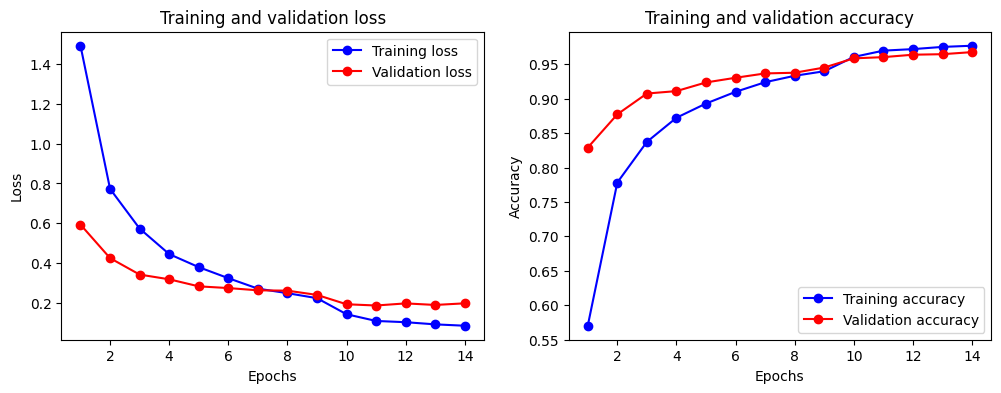

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


# Load the best model
best_model_path = '/content/drive/My Drive/models/without_attention/best_model.h5'
best_model = load_model(best_model_path)

# Define the path to your validation dataset
validation_data_dir = './data/WhichWaste_dataset/val'

# Create an instance of ImageDataGenerator
val_datagen = ImageDataGenerator(rescale=1./255)

# Create a validation data generator
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Extract true labels from the validation generator
val_true_labels = validation_generator.classes

# Make predictions on the validation data
val_preds = best_model.predict(validation_generator)

# Convert probabilities to class labels
val_preds_classes = np.argmax(val_preds, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(val_true_labels, val_preds_classes)
precision = precision_score(val_true_labels, val_preds_classes, average='macro')  # 'macro' for multiclass
recall = recall_score(val_true_labels, val_preds_classes, average='macro')
f1 = f1_score(val_true_labels, val_preds_classes, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Load the training history from the file
history_path = '/content/drive/My Drive/models/without_attention/training_history.npy'
history = np.load(history_path, allow_pickle=True).item()

# Extract the relevant data
history['loss'] = history['loss'][::-1]
history['accuracy'] = history['accuracy'][::-1]
history['val_loss'] = history['val_loss'][::-1]
history['val_accuracy'] = history['val_accuracy'][::-1]

# Plotting
epochs = range(1, len(history['loss']) + 1)


# Loss plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], 'bo-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


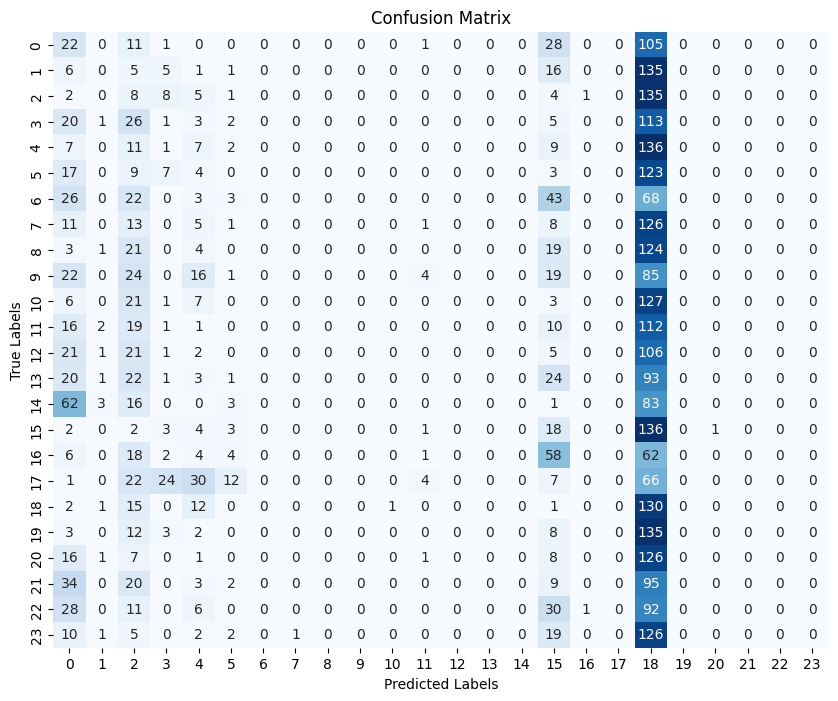

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_preds_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from time import time
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# For machine learning we use the 2 data directly (as relative pixel positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# The label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# Split into a training set and a test and keep 25% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

# Train a SVM classification model
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

# Quantitative evaluation of the model quality on the test set
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()



HTTPError: HTTP Error 403: Forbidden

###Model 3 (without attention module 100 Epochs + All evaluations)

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.applications import ResNet101, DenseNet169, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate, Flatten, BatchNormalization, Dropout, Conv2D, Activation, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from google.colab import drive

# Stacked Model
input_shape = (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

base_ResNet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_DenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
base_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_ResNet101.layers:
    layer.trainable = False
for layer in base_ResNet50.layers:
    layer.trainable = False
for layer in base_DenseNet169.layers:
    layer.trainable = False

# No CBAM for DenseNet169
model_DenseNet169 = base_DenseNet169(input_layer)
model_DenseNet169 = GlobalAveragePooling2D()(model_DenseNet169)
output_DenseNet169 = Flatten()(model_DenseNet169)

# No CBAM for ResNet101 and ResNet50
model_ResNet101 = base_ResNet101(input_layer)
model_ResNet101 = GlobalAveragePooling2D()(model_ResNet101)
output_ResNet101 = Flatten()(model_ResNet101)

model_ResNet50 = base_ResNet50(input_layer)
model_ResNet50 = GlobalAveragePooling2D()(model_ResNet50)
output_ResNet50 = Flatten()(model_ResNet50)

# Concatenate
merged = concatenate(inputs=[output_ResNet101, output_DenseNet169, output_ResNet50])

# Fully connected layers
x = BatchNormalization()(merged)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(24, activation='softmax')(x)

stacked_model = Model(inputs=input_layer, outputs=x)


94765736/94765736 [==============================] - 4s 0us/step


In [7]:
# Set the paths to your dataset
train_data_dir = './data/WhichWaste_dataset/train'
validation_data_dir = './data/WhichWaste_dataset/val'

# Set image size
img_size = (224, 224)

# Data Augmented already
# So create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

# Load and prepare training data
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 37078 images belonging to 24 classes.
Found 3970 images belonging to 24 classes.


In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, Callback
from sklearn.metrics import precision_score, recall_score, f1_score


# Custom callback to save training history after each epoch
class SaveHistoryCallback(Callback):
    def __init__(self, file_path):
        super(SaveHistoryCallback, self).__init__()
        self.file_path = file_path

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        epoch_history = {key: [value] for key, value in logs.items()}
        if os.path.exists(self.file_path):
            existing_history = np.load(self.file_path, allow_pickle=True).item()
            for key, value in existing_history.items():
                epoch_history[key] += value
        np.save(self.file_path, epoch_history)

# Function to define the learning rate schedule
def step_decay(epoch, lr):
    initial_learning_rate = 0.001
    epochs_drop = 10
    drop_factor = 0.5
    new_lr = initial_learning_rate * (drop_factor ** np.floor((1 + epoch) / epochs_drop))
    return new_lr

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(step_decay, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Model checkpoint
model_save_path = '/content/drive/My Drive/models/without_attention/best_model.h5'
model_checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Define the file path to save training history
history_file_path = '/content/drive/My Drive/models/without_attention/training_history.npy'

# Define the custom callback to save training history after each epoch
save_history_callback = SaveHistoryCallback(history_file_path)

In [ ]:
# import numpy as np
# import tensorflow as tf
# from sklearn.metrics import roc_auc_score
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# def recall_m(y_true, y_pred):
#     true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
#     possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
#     predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))


# # Load the best model if it exists
# if os.path.exists(model_save_path):
#     with tf.keras.utils.custom_object_scope({'CBAM': CBAM, 'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m}):
#         stacked_model = load_model(model_save_path)
#     print("Loaded model from", model_save_path)

#     # Extract the last completed epoch from the model's history
#     last_epoch = stacked_model.optimizer.iterations.numpy() // len(train_generator)
#     print("Resuming training from epoch", last_epoch)
# else:
#     last_epoch = 0
#     print("No existing model found, starting training from scratch.")


# stacked_model.compile(optimizer='adam', loss='categorical_crossentropy',
#                       metrics=['accuracy', precision_m, recall_m, f1_m])

# # Train
# epochs = 100
# steps_per_epoch = len(train_generator)
# validation_steps = len(validation_generator)

# history = stacked_model.fit(
#     train_generator,
#     epochs=epochs,
#     initial_epoch=last_epoch,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=validation_generator,
#     validation_steps=validation_steps,
#     callbacks=[lr_scheduler, early_stopping, model_checkpoint, save_history_callback]
# )

# # Save the last completed epoch to a file
# with open('last_completed_epoch.txt', 'w') as f:
#     f.write(str(last_epoch + len(history.history['accuracy'])))

# print("Training history saved to:", history_file_path)


No existing model found, starting training from scratch.

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
580/580 [==============================] - ETA: 0s - loss: 1.4987 - accuracy: 0.5706 - precision_m: 0.7757 - recall_m: 0.4491 - f1_m: 0.5530
Epoch 1: val_accuracy improved from -inf to 0.82569, saving model to /content/drive/My Drive/models/without_attention/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


580/580 [==============================] - 571s 914ms/step - loss: 1.4987 - accuracy: 0.5706 - precision_m: 0.7757 - recall_m: 0.4491 - f1_m: 0.5530 - val_loss: 0.5903 - val_accuracy: 0.8257 - val_precision_m: 0.9072 - val_recall_m: 0.7505 - val_f1_m: 0.8207 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
580/580 [==============================] - ETA: 0s - loss: 0.7826 - accuracy: 0.7792 - precision_m: 0.8727 - recall_m: 0.6989 - f1_m: 0.7753
Epoch 2: val_accuracy improved from 0.82569 to 0.87128, saving model to /content/drive/My Drive/models/without_attention/best_model.h5
580/580 [==============================] - 489s 843ms/step - loss: 0.7826 - accuracy: 0.7792 - precision_m: 0.8727 - recall_m: 0.6989 - f1_m: 0.7753 - val_loss: 0.4293 - val_accuracy: 0.8713 - val_precision_m: 0.9191 - val_recall_m: 0.8341 - val_f1_m: 0.8742 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
580/580 [===================

In [ ]:
# import numpy as np
# import tensorflow as tf
# from sklearn.metrics import roc_auc_score
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# def recall_m(y_true, y_pred):
#     true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
#     possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
#     predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))


# # Load the best model if it exists
# if os.path.exists(model_save_path):
#     with tf.keras.utils.custom_object_scope({'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m}):
#         stacked_model = load_model(model_save_path)
#     print("Loaded model from", model_save_path)

#     # Extract the last completed epoch from the model's history
#     last_epoch = stacked_model.optimizer.iterations.numpy() // len(train_generator)
#     print("Resuming training from epoch", last_epoch)
# else:
#     last_epoch = 0
#     print("No existing model found, starting training from scratch.")


# stacked_model.compile(optimizer='adam', loss='categorical_crossentropy',
#                       metrics=['accuracy', precision_m, recall_m, f1_m])

# # Train
# epochs = 100
# steps_per_epoch = len(train_generator)
# validation_steps = len(validation_generator)

# history = stacked_model.fit(
#     train_generator,
#     epochs=epochs,
#     initial_epoch=last_epoch,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=validation_generator,
#     validation_steps=validation_steps,
#     callbacks=[lr_scheduler, early_stopping, model_checkpoint, save_history_callback]
# )

# # Save the last completed epoch to a file
# with open('last_completed_epoch.txt', 'w') as f:
#     f.write(str(last_epoch + len(history.history['accuracy'])))

# print("Training history saved to:", history_file_path)


Loaded model from /content/drive/My Drive/models/without_attention/best_model.h5
Resuming training from epoch 8

Epoch 9: LearningRateScheduler setting learning rate to 0.001.
Epoch 9/100
580/580 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9379 - precision_m: 0.9553 - recall_m: 0.9214 - f1_m: 0.9379
Epoch 9: val_accuracy improved from -inf to 0.94761, saving model to /content/drive/My Drive/models/without_attention/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


580/580 [==============================] - 523s 840ms/step - loss: 0.2354 - accuracy: 0.9379 - precision_m: 0.9553 - recall_m: 0.9214 - f1_m: 0.9379 - val_loss: 0.2425 - val_accuracy: 0.9476 - val_precision_m: 0.9631 - val_recall_m: 0.9323 - val_f1_m: 0.9473 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0005.
Epoch 10/100
580/580 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9556 - precision_m: 0.9675 - recall_m: 0.9430 - f1_m: 0.9550
Epoch 10: val_accuracy improved from 0.94761 to 0.95617, saving model to /content/drive/My Drive/models/without_attention/best_model.h5
580/580 [==============================] - 510s 879ms/step - loss: 0.1630 - accuracy: 0.9556 - precision_m: 0.9675 - recall_m: 0.9430 - f1_m: 0.9550 - val_loss: 0.2120 - val_accuracy: 0.9562 - val_precision_m: 0.9596 - val_recall_m: 0.9439 - val_f1_m: 0.9516 - lr: 5.0000e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0005.
Epoch 11/100
580/580 [========

63/63 [==============================] - 70s 802ms/step - loss: 0.2391 - accuracy: 0.9451 - precision_m: 0.9582 - recall_m: 0.9360 - f1_m: 0.9467
Validation Loss: 0.23913104832172394
Validation Accuracy: 0.9450881481170654
Validation Precision: 0.9581575393676758
Validation Recall: 0.9360119104385376
Validation F1 Score: 0.9467282295227051
63/63 [==============================] - 52s 735ms/step
Classification Report:
                     precision    recall  f1-score   support

           alu_can       0.93      0.98      0.95       168
           battery       0.96      0.98      0.97       169
              book       0.85      0.95      0.90       164
     bulky_rubbish       0.89      0.90      0.90       171
         cardboard       0.96      0.90      0.93       173
            cd_dvd       0.96      0.82      0.88       163
    coffee_capsule       0.99      1.00      0.99       165
construction_waste       0.94      0.92      0.93       165
              cork       1.00      0.

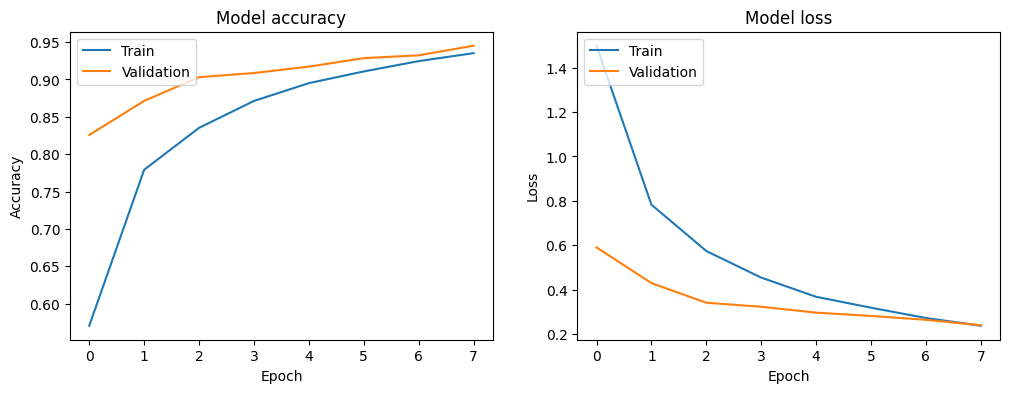

In [9]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Define custom metrics
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Function to plot training history
def plot_history(history):
    if history:
        # Reverse the order of the history data
        for key in history.keys():
            history[key] = history[key][::-1]

        # Plot training & validation accuracy values
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.show()
    else:
        print("No training history available to plot.")

# Function to evaluate the model on a generator
def evaluate_model(model, generator):
    # Evaluate the model on the validation set
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = model.evaluate(generator, verbose=1)
    print(f'Validation Loss: {val_loss}')
    print(f'Validation Accuracy: {val_accuracy}')
    print(f'Validation Precision: {val_precision}')
    print(f'Validation Recall: {val_recall}')
    print(f'Validation F1 Score: {val_f1}')

    # Generate predictions
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes

    # Generate classification report
    class_report = classification_report(y_true, y_pred_classes, target_names=generator.class_indices.keys())
    print("Classification Report:\n", class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print("Confusion Matrix:\n", conf_matrix)

    return val_accuracy, val_precision, val_recall, val_f1, class_report, conf_matrix

# Path to save and load the model
model_save_path = '/content/drive/My Drive/models/without_attention/best_model.h5'

# Load the best model
best_model = load_model(model_save_path, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})

# Evaluate the model on the validation data
val_accuracy, val_precision, val_recall, val_f1, class_report, conf_matrix = evaluate_model(best_model, validation_generator)

# Plot training history if available
try:
    history_file_path = '/content/drive/My Drive/models/without_attention/training_history.npy'
    history = np.load(history_file_path, allow_pickle=True).item()
    plot_history(history)
except FileNotFoundError:
    plot_history(None)
    print("Training history file not found.")


In [ ]:
import numpy as np

# Define the file path of the training history file
history_file_path = '/content/drive/My Drive/models/without_attention/training_history.npy'

# Load the training history
history = np.load(history_file_path, allow_pickle=True).item()

# Print the loaded history
print(history)

{'loss': [0.08484168350696564, 0.09164950251579285, 0.10255160182714462, 0.10882321000099182, 0.14257274568080902, 0.22343720495700836, 0.24843601882457733, 0.27131569385528564, 0.32391321659088135, 0.3793351352214813, 0.4449506103992462, 0.5733108520507812, 0.7728811502456665, 1.4925379753112793], 'accuracy': [0.977048397064209, 0.9753223061561584, 0.9721128344535828, 0.9699012637138367, 0.96075838804245, 0.9399374127388, 0.9333567023277283, 0.9240249991416931, 0.9100275039672852, 0.8930363059043884, 0.8723501563072205, 0.8372889757156372, 0.7782242894172668, 0.5700415372848511], 'val_loss': [0.19744598865509033, 0.18926706910133362, 0.19709034264087677, 0.186480313539505, 0.19272975623607635, 0.23974625766277313, 0.26112109422683716, 0.2628554701805115, 0.2741784453392029, 0.2828049063682556, 0.3182426989078522, 0.3419741690158844, 0.4247947633266449, 0.5932645201683044], 'val_accuracy': [0.9677581787109375, 0.9647355079650879, 0.9639798402786255, 0.9604533910751343, 0.95869016647338

###Model 3 + CBAM (ONLY DENSENET169) 100 Epochs + All Evaluations

In [10]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.applications import ResNet101, DenseNet169, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate, Flatten, BatchNormalization, Dropout, Conv2D, Activation, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from google.colab import drive


# CBAM modules
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelAttention, self).__init__()
        self.pool_types = pool_types

        self.shared_mlp = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(units=channel_in//reduction_ratio, activation='relu'),
            layers.Dense(units=channel_in, activation='sigmoid')
        ])

    def call(self, inputs):
        channel_attentions = []
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
                channel_attentions.append(self.shared_mlp(avg_pool))
            elif pool_type == 'max':
                max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
                channel_attentions.append(self.shared_mlp(max_pool))

        pooling_sums = tf.reduce_sum(tf.stack(channel_attentions, axis=0), axis=0)
        scaled = tf.expand_dims(tf.expand_dims(pooling_sums, axis=1), axis=1)
        return inputs * scaled

class ChannelPool(tf.keras.layers.Layer):
    def call(self, inputs):
        max_pool = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        mean_pool = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        return tf.concat([max_pool, mean_pool], axis=-1)

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.compress = ChannelPool()
        self.spatial_attention = tf.keras.Sequential([
            layers.Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False),
            layers.BatchNormalization(epsilon=1e-5, momentum=0.01),
        ])

    def call(self, inputs):
        x_compress = self.compress(inputs)
        x_output = self.spatial_attention(x_compress)
        scaled = tf.sigmoid(x_output)
        return inputs * scaled

class CBAM(tf.keras.Model):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max'], spatial=True):
        super(CBAM, self).__init__()
        self.spatial = spatial
        self.channel_attention = ChannelAttention(channel_in=channel_in, reduction_ratio=reduction_ratio, pool_types=pool_types)
        if self.spatial:
            self.spatial_attention = SpatialAttention(kernel_size=7)

    def call(self, inputs):
        x_out = self.channel_attention(inputs)
        if self.spatial:
            x_out = self.spatial_attention(x_out)
        return x_out

# Function to add CBAM to a base model
def cbam_block(base_model_output):
    cbam_module = CBAM(channel_in=base_model_output.shape[-1])
    return cbam_module(base_model_output)

# Stacked Model
input_shape = (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

base_ResNet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_DenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
base_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_ResNet101.layers:
    layer.trainable = False
for layer in base_ResNet50.layers:
    layer.trainable = False
for layer in base_DenseNet169.layers:
    layer.trainable = False

# CBAM only to DenseNet169
model_DenseNet169 = base_DenseNet169(input_layer)
model_DenseNet169_cbam = cbam_block(model_DenseNet169)
model_DenseNet169_cbam = GlobalAveragePooling2D()(model_DenseNet169_cbam)
output_DenseNet169_cbam = Flatten()(model_DenseNet169_cbam)

# No CBAM for ResNet101 and ResNet50
model_ResNet101 = base_ResNet101(input_layer)
model_ResNet101 = GlobalAveragePooling2D()(model_ResNet101)
output_ResNet101 = Flatten()(model_ResNet101)

model_ResNet50 = base_ResNet50(input_layer)
model_ResNet50 = GlobalAveragePooling2D()(model_ResNet50)
output_ResNet50 = Flatten()(model_ResNet50)

# Concatenate
merged = concatenate(inputs=[output_ResNet101, output_DenseNet169_cbam, output_ResNet50])

# Fully connected layers
x = BatchNormalization()(merged)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(24, activation='softmax')(x)

stacked_model = Model(inputs=input_layer, outputs=x)


In [11]:
# Set the paths to your dataset
train_data_dir = './data/WhichWaste_dataset/train'
validation_data_dir = './data/WhichWaste_dataset/val'

# Set image size
img_size = (224, 224)

# Data Augmented already
# So create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

# Load and prepare training data
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 37078 images belonging to 24 classes.
Found 3970 images belonging to 24 classes.


In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, Callback

# Custom callback to save training history after each epoch
class SaveHistoryCallback(Callback):
    def __init__(self, file_path):
        super(SaveHistoryCallback, self).__init__()
        self.file_path = file_path

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        epoch_history = {key: [value] for key, value in logs.items()}
        if os.path.exists(self.file_path):
            existing_history = np.load(self.file_path, allow_pickle=True).item()
            for key, value in existing_history.items():
                epoch_history[key] += value
        np.save(self.file_path, epoch_history)

# Function to define the learning rate schedule
def step_decay(epoch, lr):
    initial_learning_rate = 0.001
    epochs_drop = 10
    drop_factor = 0.5
    new_lr = initial_learning_rate * (drop_factor ** np.floor((1 + epoch) / epochs_drop))
    return new_lr

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(step_decay, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Model checkpoint
model_save_path = '/content/drive/My Drive/models/densenet169_cbam/best_model.h5'
model_checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Define the file path to save training history
history_file_path = '/content/drive/My Drive/models/densenet169_cbam/training_history.npy'

# Define the custom callback to save training history after each epoch
save_history_callback = SaveHistoryCallback(history_file_path)

In [ ]:
# import numpy as np
# import tensorflow as tf
# from sklearn.metrics import roc_auc_score
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# def recall_m(y_true, y_pred):
#     true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
#     possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
#     predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))


# # Load the best model if it exists
# if os.path.exists(model_save_path):
#     with tf.keras.utils.custom_object_scope({'CBAM': CBAM, 'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m}):
#         stacked_model = load_model(model_save_path)
#     print("Loaded model from", model_save_path)

#     # Extract the last completed epoch from the model's history
#     last_epoch = stacked_model.optimizer.iterations.numpy() // len(train_generator)
#     print("Resuming training from epoch", last_epoch)
# else:
#     last_epoch = 0
#     print("No existing model found, starting training from scratch.")


# stacked_model.compile(optimizer='adam', loss='categorical_crossentropy',
#                       metrics=['accuracy', precision_m, recall_m, f1_m])

# # Train
# epochs = 100
# steps_per_epoch = len(train_generator)
# validation_steps = len(validation_generator)

# history = stacked_model.fit(
#     train_generator,
#     epochs=epochs,
#     initial_epoch=last_epoch,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=validation_generator,
#     validation_steps=validation_steps,
#     callbacks=[lr_scheduler, early_stopping, model_checkpoint, save_history_callback]
# )

# # Save the last completed epoch to a file
# with open('last_completed_epoch.txt', 'w') as f:
#     f.write(str(last_epoch + len(history.history['accuracy'])))

# print("Training history saved to:", history_file_path)

No existing model found, starting training from scratch.

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
580/580 [==============================] - ETA: 0s - loss: 1.4110 - accuracy: 0.5921 - precision_m: 0.7675 - recall_m: 0.4691 - f1_m: 0.5702
Epoch 1: val_accuracy improved from -inf to 0.84610, saving model to /content/drive/My Drive/models/densenet169_cbam/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


580/580 [==============================] - 537s 886ms/step - loss: 1.4110 - accuracy: 0.5921 - precision_m: 0.7675 - recall_m: 0.4691 - f1_m: 0.5702 - val_loss: 0.5451 - val_accuracy: 0.8461 - val_precision_m: 0.9128 - val_recall_m: 0.7671 - val_f1_m: 0.8322 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
580/580 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.7845 - precision_m: 0.8738 - recall_m: 0.7109 - f1_m: 0.7832
Epoch 2: val_accuracy improved from 0.84610 to 0.88489, saving model to /content/drive/My Drive/models/densenet169_cbam/best_model.h5
580/580 [==============================] - 478s 824ms/step - loss: 0.7430 - accuracy: 0.7845 - precision_m: 0.8738 - recall_m: 0.7109 - f1_m: 0.7832 - val_loss: 0.3881 - val_accuracy: 0.8849 - val_precision_m: 0.9248 - val_recall_m: 0.8435 - val_f1_m: 0.8809 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
580/580 [====================

In [14]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Define custom metrics
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Function to plot training history
def plot_history(history):
    if history:
        # Reverse the order of the history data
        for key in history.keys():
            history[key] = history[key][::-1]

        # Plot training & validation accuracy values
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.show()
    else:
        print("No training history available to plot.")

# Function to evaluate the model on a generator
def evaluate_model(model, generator):
    # Evaluate the model on the validation set
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = model.evaluate(generator, verbose=1)
    print(f'Validation Loss: {val_loss}')
    print(f'Validation Accuracy: {val_accuracy}')
    print(f'Validation Precision: {val_precision}')
    print(f'Validation Recall: {val_recall}')
    print(f'Validation F1 Score: {val_f1}')

    # Generate predictions
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes

    # Generate classification report
    class_report = classification_report(y_true, y_pred_classes, target_names=generator.class_indices.keys())
    print("Classification Report:\n", class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print("Confusion Matrix:\n", conf_matrix)

    return val_accuracy, val_precision, val_recall, val_f1, class_report, conf_matrix

# Path to save and load the model
model_save_path = '/content/drive/My Drive/models/densenet169_cbam/best_model.h5'

# Load the best model
best_model = load_model(model_save_path, custom_objects={'CBAM': CBAM,'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})

# Evaluate the model on the validation data
val_accuracy, val_precision, val_recall, val_f1, class_report, conf_matrix = evaluate_model(best_model, validation_generator)

# Plot training history if available
try:
    history_file_path = '/content/drive/My Drive/models/densenet169_cbam/training_history.npy'
    history = np.load(history_file_path, allow_pickle=True).item()
    plot_history(history)
except FileNotFoundError:
    plot_history(None)
    print("Training history file not found.")


63/63 [==============================] - 63s 769ms/step - loss: 0.2005 - accuracy: 0.9695


ValueError: not enough values to unpack (expected 5, got 2)

In [ ]:
import numpy as np

# Define the file path of the training history file
history_file_path = '/content/drive/My Drive/models/densenet169_cbam/training_history.npy'

# Load the training history
history = np.load(history_file_path, allow_pickle=True).item()

# Print the loaded history
print(history)

{'loss': [0.07064700126647949, 0.06682178378105164, 0.07090303301811218, 0.08116992563009262, 0.08335691690444946, 0.09434634447097778, 0.09828726202249527, 0.10953805595636368, 0.14079493284225464, 0.2182227075099945, 0.2340463548898697, 0.2654334306716919, 0.3133432865142822, 0.36232802271842957, 0.4212109446525574, 0.5507394075393677, 0.742976188659668, 1.4109957218170166], 'accuracy': [0.9812827110290527, 0.9817951321601868, 0.9805005788803101, 0.9787474870681763, 0.9765899181365967, 0.9742165207862854, 0.9729489088058472, 0.9699282646179199, 0.9620529413223267, 0.9405307769775391, 0.9355682730674744, 0.9269378185272217, 0.9134527444839478, 0.8989967107772827, 0.8805221319198608, 0.8431684374809265, 0.7844544053077698, 0.5921301245689392], 'precision_m': [0.9851503372192383, 0.9856605529785156, 0.9840930700302124, 0.9831495881080627, 0.9820706844329834, 0.9799318313598633, 0.9783805012702942, 0.9772204160690308, 0.9723159074783325, 0.9582140445709229, 0.9542709589004517, 0.94815158